<a href="https://colab.research.google.com/github/kate-simonova/cancer-subtyping/blob/main/03_standard_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder implemetation

The goal of this notebook is to implement a standard autoencoder and apply clustering on this latent space.

**Three metrics were selected for measuring the quality of the model:**

* Sihouette score - the better, the value is closer to 1
* Davins-Bouldin score - the better, the value is closer to 0
* Adjusted Rand Index - the better, the value is closer to 1

## Data Loading and installation of packages

In [ ]:
!pip install -U kaleido
!pip install umap-learn
#!pip install keras==2.11.0

In [ ]:
# importing necessary packages
from google.colab import drive
drive.mount('/content/drive') 
path = "/content/drive/MyDrive/MY_DATA/merged/"

import re

import numpy as np
import pandas as pd
#import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils import plot_model
from keras.layers import Reshape, Lambda, Dropout, BatchNormalization, Dense, Input, concatenate
from keras import regularizers
from keras.utils.vis_utils import plot_model
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger

import gc
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from keras import initializers
from keras import backend as K

from keras.models import Model, Sequential
from keras.losses import mean_squared_error
from keras.metrics import binary_crossentropy
from sklearn.model_selection import KFold
from keras.optimizers import SGD


Mounted at /content/drive


In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

import keras
print(keras.__version__)

4
2.12.0


# Loading and preprocessing data

In [ ]:
test_df = pd.read_csv(f"{path}/split_circle/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0).T
test_df.shape

(2156, 22596)

In [ ]:
y_test = pd.read_csv(f"{path}/split_circle/y_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0)
#y_test = y_test.reset_index(drop=True)
#y_test.index = test_df.index
y_test.shape

(2156, 7)

In [ ]:
train_df = pd.read_csv(f"{path}/split_circle/X_train_A_merged_CRC_BRCA.csv.tar.gz", compression="gzip", index_col=0).T
train_df.shape

(11544, 22596)

In [ ]:
y_train = pd.read_csv(f"{path}/split_circle/y_train_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0)
#y_train = y_train.reset_index(drop=True)
#y_train.index = train_df.index
y_train.shape

(11544, 7)

# Dimensionality reduction with PCA

In [ ]:
pca = PCA(0.95).fit(train_df)
x_train = pca.transform(train_df)
x_test = pca.transform(test_df)
print(x_train.shape)
print(x_test.shape)

(11544, 4557)
(2156, 4557)


In [ ]:
x_test = pd.DataFrame(x_test, index=test_df.index)
x_train = pd.DataFrame(x_train, index=train_df.index)

In [ ]:
x_test.shape

(2156, 4557)

In [ ]:
x_test.columns = ["PC"+ str(i+1) for i in range(4557)]

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(x_train, y_train["Label"], test_size=0.2, random_state=42, stratify=y_train["Label"])

In [ ]:
X_tr.shape

(9235, 4557)

## Oversampling and synthetic data generation 

In [ ]:
mapp = LabelEncoder()

y_train_adasyn = mapp.fit_transform(y_tr).ravel()

before_counter = Counter(y_tr)
print('Before', before_counter)

ada = ADASYN(random_state=0, sampling_strategy='all')
x_train_ada, y_train_ada = ada.fit_resample(X_tr, y_train_adasyn)

after_counter = Counter(y_train_ada)
print('After', after_counter)

Before Counter({'Luminal A': 3405, 'Luminal B': 1789, 'Basal-like': 1323, 'Her2': 861, 'CMS2': 620, 'Normal-like': 393, 'CMS4': 301, 'CMS1': 229, 'CMS3': 185, 'Claudin-low': 129})
After Counter({9: 3446, 3: 3417, 5: 3416, 1: 3410, 7: 3405, 2: 3394, 4: 3390, 6: 3386, 0: 3341, 8: 3314})


In [ ]:
mapping = dict(zip(mapp.classes_, mapp.transform(mapp.classes_)))
print(mapping)

{'Basal-like': 0, 'CMS1': 1, 'CMS2': 2, 'CMS3': 3, 'CMS4': 4, 'Claudin-low': 5, 'Her2': 6, 'Luminal A': 7, 'Luminal B': 8, 'Normal-like': 9}


In [ ]:
x_train_ada = pd.DataFrame(x_train_ada)
y_train_ada = pd.DataFrame(y_train_ada)
y_train_ada.columns = ["Label"]

In [ ]:
# temporary saving
x_train_ada.to_pickle(f"{path}/pickle/x_train_ada_circle.pkl")
y_train_ada.to_pickle(f"{path}/pickle/y_train_ada_circle.pkl")

X_val.to_pickle(f"{path}/pickle/X_val_circle.pkl")
y_val.to_pickle(f"{path}/pickle/y_val_circle.pkl")

x_test.to_pickle(f"{path}/pickle/x_test_circle.pkl")
y_test.to_pickle(f"{path}/pickle/y_test_circle.pkl")

NameError: ignored

In [ ]:
x_train.columns = ["PC" + str(i+1) for i in range(4557)]
x_train_ada.columns = ["PC" + str(i+1) for i in range(4557)]

In [ ]:
y_train_ada["New"] = [1 if x in range(12203) else 0 for x in y_train_ada.index]

y_train_adasyn = pd.DataFrame(y_train_adasyn)
y_train_adasyn.columns = ["Label"]
y_train_adasyn["New"] = 1
x_train.index = y_train_adasyn.index

In [ ]:
# Implementation of graph before/after oversampling 
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(x_train["PC1"], x_train["PC2"], label="Original points",
                 alpha=0.5, s=2)
ax1.set_title('Original dataset')

c0 = ax2.scatter(x_train_ada[y_train_ada["New"] == 1]["PC1"], x_train_ada[y_train_ada["New"] == 1]["PC2"],
            label="New points", alpha=.5, s=2)
c1 = ax2.scatter(x_train_ada[y_train_ada["New"] == 0]["PC1"], x_train_ada[y_train_ada["New"] == 0]["PC2"],
            label="Original points", alpha=.5, s=2)

ax2.set_title('Oversampled dataset')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-4, 6])
    ax.set_ylim([-4, 4])
    ax.set_ylabel("PC2")
    ax.set_xlabel("PC1")

plt.figlegend((c0, c1), ('Original points', 'New points'), loc='lower center',
              ncol=2, labelspacing=0., fontsize=8)
plt.tight_layout(pad=2)
plt.savefig(f"{path}/img/before_after_oversampling_split_circle_new_old.pdf", format="pdf")
plt.show()

## Autoencoder


This part is used for explaration of the model performance in one iteration.

In [ ]:
y_train_ada = pd.read_pickle(f"{path}/pickle/y_train_ada_circle.pkl")
x_train_ada = pd.read_pickle(f"{path}/pickle/x_train_ada_circle.pkl")
x_test = pd.read_pickle(f"{path}/pickle/x_test_circle.pkl")
y_test = pd.read_pickle(f"{path}/pickle/y_test_circle.pkl")
X_val = pd.read_pickle(f"{path}/pickle/X_val_circle.pkl")
y_val = pd.read_pickle(f"{path}/pickle/y_val_circle.pkl")
x_train_ada.shape

(33919, 4557)

In [ ]:
from keras.layers.activation.leaky_relu import LeakyReLU

def autoencoder(dims, act='tanh', init='glorot_uniform'):
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], kernel_initializer=init, name='encoder_%d' % i)(x) # Dense act and kernel_initializer
        x = BatchNormalization(name='batch_norm_%d' % i)(x) # Add batch normalization layer after dense layer
        #x = LeakyReLU()(x)
   
    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], kernel_initializer=init, name='decoder_%d' % i)(x) # activation=act, kernel_initializer=init Dense
        x = BatchNormalization(name='batch_norm_%d' % (n_stacks-i))(x) # Add batch normalization layer after dense layer
        #x = LeakyReLU()(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [ ]:
dims = [4557, 1024, 64]

init = VarianceScaling(scale=1. / 2., mode='fan_avg',
                      distribution='uniform',
                      seed=0)

epochs = 1000
batch_size = 1024

optimizer = SGD(learning_rate=0.2, decay=1e-5, momentum=0.9, nesterov=True)

In [ ]:
model, encoder = autoencoder(dims, init=init)
model.compile(optimizer=optimizer, loss='mse')

csv_logger = CSVLogger(f'{path}/log_ae.csv', append=True, separator=';')

history = model.fit(x_train_ada, x_train_ada, batch_size=batch_size, epochs=epochs, validation_data=(X_val, X_val), callbacks=[csv_logger])

Epoch 1/1000
34/34 [==============================] - 2s 46ms/step - loss: 0.5058 - val_loss: 0.5433
Epoch 2/1000
34/34 [==============================] - 1s 41ms/step - loss: 0.3650 - val_loss: 0.4802
Epoch 3/1000
34/34 [==============================] - 1s 44ms/step - loss: 0.3381 - val_loss: 0.4598
Epoch 4/1000
34/34 [==============================] - 1s 39ms/step - loss: 0.3229 - val_loss: 0.4464
Epoch 5/1000
34/34 [==============================] - 1s 36ms/step - loss: 0.3103 - val_loss: 0.4358
Epoch 6/1000
34/34 [==============================] - 1s 36ms/step - loss: 0.3006 - val_loss: 0.4275
Epoch 7/1000
34/34 [==============================] - 1s 37ms/step - loss: 0.2926 - val_loss: 0.4203
Epoch 8/1000
34/34 [==============================] - 1s 42ms/step - loss: 0.2854 - val_loss: 0.4136
Epoch 9/1000
34/34 [==============================] - 1s 42ms/step - loss: 0.2789 - val_loss: 0.4070
Epoch 10/1000
34/34 [==============================] - 1s 39ms/step - loss: 0.2735 - val_lo

In [ ]:
encoder.save(f"{path}/ae_encoder.h5")

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

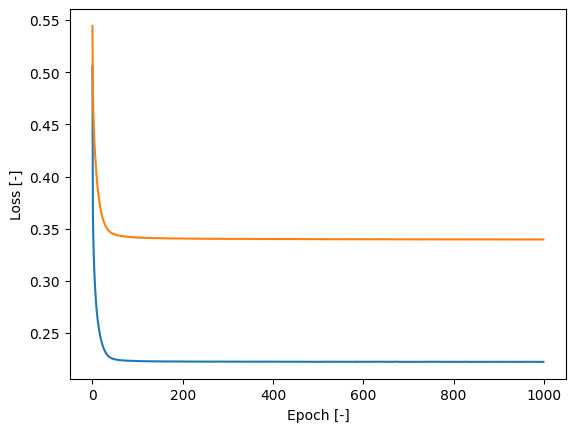

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [-]")
plt.savefig(f'{path}/figure1.pdf')

In [ ]:
print(history.history["loss"][-1],history.history["val_loss"][-1])

0.22234980762004852 0.3397122919559479


### Applying pretrained autoencoder on testing data

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(x_test_encoded)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(x_test_encoded, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(x_test_encoded, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

3/3 [==============================] - 0s 9ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhuette: -0.03799999877810478 ARI 0.192 Davies-Bouldin 3.836


 Clearing metrics below for the new round of calculations.

In [ ]:
del encoder, model
K.clear_session()

gc.collect()

4981

## Manual autoencoder tuning - Grid Search

The implementation below contains all steps above in a loop for preselected hyperparamenters and CV=5.

In [ ]:
# hyperarameters
batch_sizes = [64, 128, 256, 512, 1024]
epochs = [200, 500, 1000]
learning_rates = [0.1, 0.2]


# constant values
#dims = [4557, 1024, 64]
init = VarianceScaling(scale=1. / 2., mode='fan_avg',
                      distribution='uniform',
                      seed=0)
csv_logger = CSVLogger(f'{path}/logs_hyperparameter_tuning.csv', append=True, separator=';')

def autoencoder(dims, act='tanh', init='glorot_uniform', batch_norm=True):
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x) # Dense act and kernel_initializer
        if batch_norm:
            x = BatchNormalization(name='batch_norm_%d' % i)(x) # Add batch normalization layer after dense layer

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x) # activation=act, kernel_initializer=init Dense
        if batch_norm:
            x = BatchNormalization(name='batch_norm_%d' % (n_stacks-i))(x) # Add batch normalization layer after dense layer
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [ ]:
l, cnt = [], 0

kf = KFold(n_splits=5, shuffle=True, random_state=811)

for lr in learning_rates: # one hyperparameter
  for epoch in epochs:  # second hyperparameter
    for batch_size in batch_sizes: # third hyperparameter
      for train_index, val_index in kf.split(train_df.index): #validation
        X_train = train_df.iloc[train_index, :]
        y_tr = y_train.iloc[train_index, :]
        X_valid = train_df.iloc[val_index, :]
        y_valid = y_train.iloc[val_index, :]

        pca = PCA(0.95).fit(X_train)
        x_train = pca.transform(X_train)
        x_val = pca.transform(X_valid)

        mapp = LabelEncoder()

        y_train_adasyn = mapp.fit_transform(y_tr["Label"]).ravel()

        ada = ADASYN(random_state=0, sampling_strategy='all')
        x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train_adasyn)
        dims = [x_train_ada.shape[1], 1024, 64]
        optimizer = SGD(learning_rate=lr, decay=1e-5, momentum=0.9, nesterov=True)
        model, encoder = autoencoder(dims, init=init)
        model.compile(optimizer=optimizer, loss='mse')

        csv_logger = CSVLogger(f'{path}/log_ae.csv', append=True, separator=';')

        history = model.fit(x_train_ada, x_train_ada, batch_size=batch_size, epochs=epoch, validation_data=(x_val, x_val), callbacks=[csv_logger])
        X_val_pred = encoder.predict(x_val, batch_size=batch_size)
        
        km = KMeans(n_clusters=10, random_state=42)
        y_pred = km.fit_predict(X_val_pred)
        ari = adjusted_rand_score(y_pred, y_valid["Label"])

        silhouetteScore = silhouette_score(X_val_pred, y_valid["Label"], metric="euclidean")
        davies_bouldinScore = davies_bouldin_score(X_val_pred, y_valid["Label"])

        l.append((lr, epoch, batch_size, history.history["loss"][-1], history.history["val_loss"][-1], silhouetteScore, davies_bouldinScore, ari))
        print(cnt, l[-1])
        del model, encoder, history
        K.clear_session()
        gc.collect()
      ae_df = pd.DataFrame.from_records(l, columns=["Learning rate", "epoch", "Batch size", "Loss", "Validation loss", "Silhouette", "DB score", "ARI"])
      ae_df.to_csv(f"{path}/autoencoder_grid_search.csv")

Epoch 1/200
523/523 [==============================] - 7s 5ms/step - loss: 0.3794 - val_loss: 0.3456
Epoch 2/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2968 - val_loss: 0.3096
Epoch 3/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2769 - val_loss: 0.2956
Epoch 4/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2690 - val_loss: 0.2902
Epoch 5/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2658 - val_loss: 0.2883
Epoch 6/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2643 - val_loss: 0.2871
Epoch 7/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2625 - val_loss: 0.2863
Epoch 8/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2613 - val_loss: 0.2855
Epoch 9/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2596 - val_loss: 0.2849
Epoch 10/200
523/523 [==============================] - 3s 5ms/step - loss: 0.2581 - val_lo

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 64, 0.1703566461801529, 0.2805897891521454, 0.02977198, 3.92818215301005, 0.1844479829446896)
Epoch 1/200
531/531 [==============================] - 3s 5ms/step - loss: 0.3776 - val_loss: 0.3409
Epoch 2/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2959 - val_loss: 0.3061
Epoch 3/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2757 - val_loss: 0.2920
Epoch 4/200
531/531 [==============================] - 2s 5ms/step - loss: 0.2678 - val_loss: 0.2869
Epoch 5/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2647 - val_loss: 0.2849
Epoch 6/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2629 - val_loss: 0.2838
Epoch 7/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2616 - val_loss: 0.2830
Epoch 8/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2598 - val_loss: 0.2822
Epoch 9/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2583 - v

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 64, 0.16867779195308685, 0.27804461121559143, 0.028582005, 4.008982571006784, 0.2394030921175509)
Epoch 1/200
530/530 [==============================] - 4s 5ms/step - loss: 0.3788 - val_loss: 0.3414
Epoch 2/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2963 - val_loss: 0.3043
Epoch 3/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2764 - val_loss: 0.2909
Epoch 4/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2687 - val_loss: 0.2863
Epoch 5/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2654 - val_loss: 0.2842
Epoch 6/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2637 - val_loss: 0.2830
Epoch 7/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2626 - val_loss: 0.2824
Epoch 8/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2608 - val_loss: 0.2815
Epoch 9/200
530/530 [==============================] - 3s 5ms/step - loss: 0.2595

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 64, 0.1690361350774765, 0.27798065543174744, 0.02678057, 3.9189183686114646, 0.22460513568087837)
Epoch 1/200
532/532 [==============================] - 3s 5ms/step - loss: 0.3768 - val_loss: 0.3425
Epoch 2/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2949 - val_loss: 0.3073
Epoch 3/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2747 - val_loss: 0.2935
Epoch 4/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2674 - val_loss: 0.2887
Epoch 5/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2644 - val_loss: 0.2865
Epoch 6/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2625 - val_loss: 0.2853
Epoch 7/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2612 - val_loss: 0.2843
Epoch 8/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2596 - val_loss: 0.2836
Epoch 9/200
532/532 [==============================] - 3s 5ms/step - loss: 0.2579

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 64, 0.16905750334262848, 0.2791891098022461, 0.0303595, 3.953265475941371, 0.20828979791717725)
Epoch 1/200
531/531 [==============================] - 4s 6ms/step - loss: 0.3760 - val_loss: 0.3442
Epoch 2/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2952 - val_loss: 0.3082
Epoch 3/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2751 - val_loss: 0.2939
Epoch 4/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2675 - val_loss: 0.2887
Epoch 5/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2641 - val_loss: 0.2867
Epoch 6/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2624 - val_loss: 0.2852
Epoch 7/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2609 - val_loss: 0.2845
Epoch 8/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2595 - val_loss: 0.2837
Epoch 9/200
531/531 [==============================] - 3s 5ms/step - loss: 0.2581 -

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 64, 0.16934463381767273, 0.2780674993991852, 0.030649493, 3.9102417848418143, 0.19721044563299456)
Epoch 1/200
262/262 [==============================] - 2s 7ms/step - loss: 0.4209 - val_loss: 0.3988
Epoch 2/200
262/262 [==============================] - 2s 6ms/step - loss: 0.3261 - val_loss: 0.3440
Epoch 3/200
262/262 [==============================] - 2s 6ms/step - loss: 0.2981 - val_loss: 0.3213
Epoch 4/200
262/262 [==============================] - 2s 6ms/step - loss: 0.2829 - val_loss: 0.3077
Epoch 5/200
262/262 [==============================] - 2s 6ms/step - loss: 0.2735 - val_loss: 0.2994
Epoch 6/200
262/262 [==============================] - 2s 6ms/step - loss: 0.2677 - val_loss: 0.2944
Epoch 7/200
262/262 [==============================] - 2s 6ms/step - loss: 0.2641 - val_loss: 0.2911
Epoch 8/200
262/262 [==============================] - 2s 6ms/step - loss: 0.2620 - val_loss: 0.2893
Epoch 9/200
262/262 [==============================] - 2s 6ms/step - loss: 0.260

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 128, 0.17043772339820862, 0.27712562680244446, 0.03255251, 3.805178763158916, 0.23614560928255107)
Epoch 1/200
266/266 [==============================] - 2s 7ms/step - loss: 0.4180 - val_loss: 0.3921
Epoch 2/200
266/266 [==============================] - 2s 6ms/step - loss: 0.3241 - val_loss: 0.3388
Epoch 3/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2966 - val_loss: 0.3177
Epoch 4/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2815 - val_loss: 0.3043
Epoch 5/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2720 - val_loss: 0.2957
Epoch 6/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2663 - val_loss: 0.2908
Epoch 7/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2631 - val_loss: 0.2878
Epoch 8/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2609 - val_loss: 0.2860
Epoch 9/200
266/266 [==============================] - 2s 6ms/step - loss: 0.259

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 128, 0.16864146292209625, 0.2748028337955475, 0.031207059, 3.8619313631744796, 0.24470661453712303)
Epoch 1/200
265/265 [==============================] - 2s 7ms/step - loss: 0.4210 - val_loss: 0.3913
Epoch 2/200
265/265 [==============================] - 2s 6ms/step - loss: 0.3266 - val_loss: 0.3389
Epoch 3/200
265/265 [==============================] - 2s 6ms/step - loss: 0.2979 - val_loss: 0.3159
Epoch 4/200
265/265 [==============================] - 2s 6ms/step - loss: 0.2827 - val_loss: 0.3029
Epoch 5/200
265/265 [==============================] - 2s 6ms/step - loss: 0.2732 - val_loss: 0.2948
Epoch 6/200
265/265 [==============================] - 2s 6ms/step - loss: 0.2675 - val_loss: 0.2898
Epoch 7/200
265/265 [==============================] - 2s 6ms/step - loss: 0.2642 - val_loss: 0.2869
Epoch 8/200
265/265 [==============================] - 2s 6ms/step - loss: 0.2617 - val_loss: 0.2851
Epoch 9/200
265/265 [==============================] - 2s 6ms/step - loss: 0.26

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 128, 0.16889573633670807, 0.27438896894454956, 0.029705096, 3.7976828570403187, 0.22783449581094445)
Epoch 1/200
266/266 [==============================] - 2s 7ms/step - loss: 0.4188 - val_loss: 0.3945
Epoch 2/200
266/266 [==============================] - 2s 6ms/step - loss: 0.3240 - val_loss: 0.3409
Epoch 3/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2960 - val_loss: 0.3186
Epoch 4/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2809 - val_loss: 0.3055
Epoch 5/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2715 - val_loss: 0.2973
Epoch 6/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2659 - val_loss: 0.2923
Epoch 7/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2625 - val_loss: 0.2895
Epoch 8/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2604 - val_loss: 0.2878
Epoch 9/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 128, 0.16958701610565186, 0.2759590446949005, 0.03347822, 3.8103528901047086, 0.23678921816434767)
Epoch 1/200
266/266 [==============================] - 2s 7ms/step - loss: 0.4170 - val_loss: 0.3961
Epoch 2/200
266/266 [==============================] - 2s 6ms/step - loss: 0.3243 - val_loss: 0.3422
Epoch 3/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2962 - val_loss: 0.3200
Epoch 4/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2811 - val_loss: 0.3063
Epoch 5/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2717 - val_loss: 0.2979
Epoch 6/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2660 - val_loss: 0.2927
Epoch 7/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2624 - val_loss: 0.2899
Epoch 8/200
266/266 [==============================] - 2s 6ms/step - loss: 0.2606 - val_loss: 0.2879
Epoch 9/200
266/266 [==============================] - 2s 6ms/step - loss: 0.259

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 128, 0.16942523419857025, 0.27472010254859924, 0.033681028, 3.7343160600186325, 0.2153359372546561)
Epoch 1/200
131/131 [==============================] - 2s 10ms/step - loss: 0.4724 - val_loss: 0.4729
Epoch 2/200
131/131 [==============================] - 1s 8ms/step - loss: 0.3631 - val_loss: 0.3980
Epoch 3/200
131/131 [==============================] - 1s 8ms/step - loss: 0.3330 - val_loss: 0.3629
Epoch 4/200
131/131 [==============================] - 1s 9ms/step - loss: 0.3132 - val_loss: 0.3436
Epoch 5/200
131/131 [==============================] - 1s 9ms/step - loss: 0.2997 - val_loss: 0.3303
Epoch 6/200
131/131 [==============================] - 1s 8ms/step - loss: 0.2901 - val_loss: 0.3207
Epoch 7/200
131/131 [==============================] - 1s 8ms/step - loss: 0.2828 - val_loss: 0.3131
Epoch 8/200
131/131 [==============================] - 1s 8ms/step - loss: 0.2769 - val_loss: 0.3072
Epoch 9/200
131/131 [==============================] - 1s 8ms/step - loss: 0.2

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 256, 0.18629270792007446, 0.2726600468158722, 0.03195554, 3.781221428906992, 0.21245301505216996)
Epoch 1/200
133/133 [==============================] - 2s 10ms/step - loss: 0.4692 - val_loss: 0.4662
Epoch 2/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3621 - val_loss: 0.3922
Epoch 3/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3310 - val_loss: 0.3570
Epoch 4/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3112 - val_loss: 0.3385
Epoch 5/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2984 - val_loss: 0.3265
Epoch 6/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2890 - val_loss: 0.3169
Epoch 7/200
133/133 [==============================] - 1s 9ms/step - loss: 0.2815 - val_loss: 0.3096
Epoch 8/200
133/133 [==============================] - 1s 9ms/step - loss: 0.2757 - val_loss: 0.3036
Epoch 9/200
133/133 [==============================] - 1s 8ms/step - loss: 0.270

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 256, 0.18418660759925842, 0.2702886760234833, 0.030675597, 3.8388033495892726, 0.234592111060444)
Epoch 1/200
133/133 [==============================] - 2s 10ms/step - loss: 0.4728 - val_loss: 0.4640
Epoch 2/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3633 - val_loss: 0.3899
Epoch 3/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3331 - val_loss: 0.3567
Epoch 4/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3133 - val_loss: 0.3377
Epoch 5/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2996 - val_loss: 0.3248
Epoch 6/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2898 - val_loss: 0.3149
Epoch 7/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2823 - val_loss: 0.3076
Epoch 8/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2766 - val_loss: 0.3020
Epoch 9/200
133/133 [==============================] - 1s 8ms/step - loss: 0.271

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 256, 0.18436254560947418, 0.2699841558933258, 0.028844468, 3.7646288684275424, 0.2225747285502202)
Epoch 1/200
133/133 [==============================] - 2s 10ms/step - loss: 0.4699 - val_loss: 0.4664
Epoch 2/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3612 - val_loss: 0.3939
Epoch 3/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3306 - val_loss: 0.3594
Epoch 4/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3106 - val_loss: 0.3404
Epoch 5/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2975 - val_loss: 0.3276
Epoch 6/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2878 - val_loss: 0.3179
Epoch 7/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2805 - val_loss: 0.3106
Epoch 8/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2747 - val_loss: 0.3049
Epoch 9/200
133/133 [==============================] - 1s 8ms/step - loss: 0.27

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 256, 0.18473665416240692, 0.27160802483558655, 0.031788837, 3.80253383559324, 0.23405047470260942)
Epoch 1/200
133/133 [==============================] - 2s 11ms/step - loss: 0.4663 - val_loss: 0.4714
Epoch 2/200
133/133 [==============================] - 1s 9ms/step - loss: 0.3620 - val_loss: 0.3960
Epoch 3/200
133/133 [==============================] - 1s 9ms/step - loss: 0.3310 - val_loss: 0.3612
Epoch 4/200
133/133 [==============================] - 1s 8ms/step - loss: 0.3114 - val_loss: 0.3414
Epoch 5/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2978 - val_loss: 0.3287
Epoch 6/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2881 - val_loss: 0.3190
Epoch 7/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2809 - val_loss: 0.3116
Epoch 8/200
133/133 [==============================] - 1s 8ms/step - loss: 0.2750 - val_loss: 0.3057
Epoch 9/200
133/133 [==============================] - 1s 8ms/step - loss: 0.27

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 256, 0.18517929315567017, 0.2704865634441376, 0.032206766, 3.735661328173447, 0.21626717652441943)
Epoch 1/200
66/66 [==============================] - 2s 17ms/step - loss: 0.5391 - val_loss: 0.5357
Epoch 2/200
66/66 [==============================] - 1s 13ms/step - loss: 0.4027 - val_loss: 0.4720
Epoch 3/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3712 - val_loss: 0.4277
Epoch 4/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3517 - val_loss: 0.3974
Epoch 5/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3370 - val_loss: 0.3773
Epoch 6/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3249 - val_loss: 0.3622
Epoch 7/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3151 - val_loss: 0.3511
Epoch 8/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3071 - val_loss: 0.3424
Epoch 9/200
66/66 [==============================] - 1s 13ms/step - loss: 0.3005 - val_l

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 512, 0.21466189622879028, 0.2736956477165222, 0.029838169, 3.838621240070956, 0.20219654885068924)
Epoch 1/200
67/67 [==============================] - 2s 18ms/step - loss: 0.5339 - val_loss: 0.5264
Epoch 2/200
67/67 [==============================] - 1s 13ms/step - loss: 0.4012 - val_loss: 0.4657
Epoch 3/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3707 - val_loss: 0.4220
Epoch 4/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3505 - val_loss: 0.3914
Epoch 5/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3353 - val_loss: 0.3710
Epoch 6/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3229 - val_loss: 0.3564
Epoch 7/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3134 - val_loss: 0.3458
Epoch 8/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3055 - val_loss: 0.3379
Epoch 9/200
67/67 [==============================] - 1s 13ms/step - loss: 0.2991 - val_l

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 512, 0.21230511367321014, 0.27075275778770447, 0.028877195, 3.8827544130057476, 0.23164165634347045)
Epoch 1/200
67/67 [==============================] - 2s 17ms/step - loss: 0.5388 - val_loss: 0.5248
Epoch 2/200
67/67 [==============================] - 1s 13ms/step - loss: 0.4023 - val_loss: 0.4632
Epoch 3/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3714 - val_loss: 0.4196
Epoch 4/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3516 - val_loss: 0.3894
Epoch 5/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3369 - val_loss: 0.3697
Epoch 6/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3252 - val_loss: 0.3562
Epoch 7/200
67/67 [==============================] - 1s 14ms/step - loss: 0.3154 - val_loss: 0.3455
Epoch 8/200
67/67 [==============================] - 1s 14ms/step - loss: 0.3072 - val_loss: 0.3369
Epoch 9/200
67/67 [==============================] - 1s 14ms/step - loss: 0.3005 - val

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 512, 0.2125099152326584, 0.2704858183860779, 0.026916504, 3.817905524150574, 0.201529226262117)
Epoch 1/200
67/67 [==============================] - 2s 18ms/step - loss: 0.5373 - val_loss: 0.5282
Epoch 2/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3999 - val_loss: 0.4656
Epoch 3/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3687 - val_loss: 0.4229
Epoch 4/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3495 - val_loss: 0.3931
Epoch 5/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3346 - val_loss: 0.3727
Epoch 6/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3224 - val_loss: 0.3585
Epoch 7/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3127 - val_loss: 0.3479
Epoch 8/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3049 - val_loss: 0.3396
Epoch 9/200
67/67 [==============================] - 1s 13ms/step - loss: 0.2984 - val_loss

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 512, 0.2124718278646469, 0.2722206711769104, 0.029483832, 3.826250238636939, 0.21810360216703753)
Epoch 1/200
67/67 [==============================] - 2s 17ms/step - loss: 0.5310 - val_loss: 0.5293
Epoch 2/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3993 - val_loss: 0.4704
Epoch 3/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3705 - val_loss: 0.4267
Epoch 4/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3500 - val_loss: 0.3950
Epoch 5/200
67/67 [==============================] - 1s 13ms/step - loss: 0.3349 - val_loss: 0.3743
Epoch 6/200
67/67 [==============================] - 1s 14ms/step - loss: 0.3229 - val_loss: 0.3598
Epoch 7/200
67/67 [==============================] - 1s 14ms/step - loss: 0.3132 - val_loss: 0.3492
Epoch 8/200
67/67 [==============================] - 1s 14ms/step - loss: 0.3054 - val_loss: 0.3406
Epoch 9/200
67/67 [==============================] - 1s 14ms/step - loss: 0.2987 - val_lo

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 512, 0.21247123181819916, 0.2716176211833954, 0.031578492, 3.746022847248271, 0.20727763633338614)
Epoch 1/200
33/33 [==============================] - 2s 34ms/step - loss: 0.6218 - val_loss: 0.5672
Epoch 2/200
33/33 [==============================] - 1s 24ms/step - loss: 0.4552 - val_loss: 0.5355
Epoch 3/200
33/33 [==============================] - 1s 24ms/step - loss: 0.4127 - val_loss: 0.5004
Epoch 4/200
33/33 [==============================] - 1s 25ms/step - loss: 0.3905 - val_loss: 0.4719
Epoch 5/200
33/33 [==============================] - 1s 25ms/step - loss: 0.3758 - val_loss: 0.4482
Epoch 6/200
33/33 [==============================] - 1s 26ms/step - loss: 0.3642 - val_loss: 0.4280
Epoch 7/200
33/33 [==============================] - 1s 24ms/step - loss: 0.3547 - val_loss: 0.4108
Epoch 8/200
33/33 [==============================] - 1s 25ms/step - loss: 0.3466 - val_loss: 0.3974
Epoch 9/200
33/33 [==============================] - 1s 24ms/step - loss: 0.3394 - val_l

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 1024, 0.2414788454771042, 0.28063276410102844, 0.031409822, 3.9219245780535394, 0.16068319461280062)
Epoch 1/200
34/34 [==============================] - 2s 31ms/step - loss: 0.6165 - val_loss: 0.5552
Epoch 2/200
34/34 [==============================] - 1s 23ms/step - loss: 0.4487 - val_loss: 0.5257
Epoch 3/200
34/34 [==============================] - 1s 23ms/step - loss: 0.4101 - val_loss: 0.4914
Epoch 4/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3893 - val_loss: 0.4644
Epoch 5/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3748 - val_loss: 0.4408
Epoch 6/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3630 - val_loss: 0.4202
Epoch 7/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3531 - val_loss: 0.4032
Epoch 8/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3445 - val_loss: 0.3900
Epoch 9/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3370 - val

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 1024, 0.23924843966960907, 0.27740660309791565, 0.03200194, 3.9122170473185514, 0.20169377501974708)
Epoch 1/200
34/34 [==============================] - 2s 32ms/step - loss: 0.6217 - val_loss: 0.5567
Epoch 2/200
34/34 [==============================] - 1s 23ms/step - loss: 0.4549 - val_loss: 0.5252
Epoch 3/200
34/34 [==============================] - 1s 23ms/step - loss: 0.4123 - val_loss: 0.4897
Epoch 4/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3902 - val_loss: 0.4621
Epoch 5/200
34/34 [==============================] - 1s 24ms/step - loss: 0.3757 - val_loss: 0.4386
Epoch 6/200
34/34 [==============================] - 1s 24ms/step - loss: 0.3639 - val_loss: 0.4181
Epoch 7/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3542 - val_loss: 0.4013
Epoch 8/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3458 - val_loss: 0.3882
Epoch 9/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3386 - val

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 1024, 0.24012017250061035, 0.276777446269989, 0.02871176, 3.8203647873650737, 0.17961899686283514)
Epoch 1/200
34/34 [==============================] - 2s 31ms/step - loss: 0.6207 - val_loss: 0.5603
Epoch 2/200
34/34 [==============================] - 1s 23ms/step - loss: 0.4520 - val_loss: 0.5279
Epoch 3/200
34/34 [==============================] - 1s 24ms/step - loss: 0.4093 - val_loss: 0.4926
Epoch 4/200
34/34 [==============================] - 1s 24ms/step - loss: 0.3872 - val_loss: 0.4642
Epoch 5/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3729 - val_loss: 0.4407
Epoch 6/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3617 - val_loss: 0.4214
Epoch 7/200
34/34 [==============================] - 1s 24ms/step - loss: 0.3521 - val_loss: 0.4048
Epoch 8/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3437 - val_loss: 0.3916
Epoch 9/200
34/34 [==============================] - 1s 24ms/step - loss: 0.3362 - val_l

3/3 [==============================] - 0s 7ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 1024, 0.23906196653842926, 0.2787390649318695, 0.03142514, 3.869072012640152, 0.19524111022592705)
Epoch 1/200
34/34 [==============================] - 2s 32ms/step - loss: 0.6133 - val_loss: 0.5609
Epoch 2/200
34/34 [==============================] - 1s 24ms/step - loss: 0.4453 - val_loss: 0.5284
Epoch 3/200
34/34 [==============================] - 1s 25ms/step - loss: 0.4069 - val_loss: 0.4948
Epoch 4/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3884 - val_loss: 0.4691
Epoch 5/200
34/34 [==============================] - 1s 22ms/step - loss: 0.3746 - val_loss: 0.4452
Epoch 6/200
34/34 [==============================] - 1s 22ms/step - loss: 0.3626 - val_loss: 0.4248
Epoch 7/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3525 - val_loss: 0.4077
Epoch 8/200
34/34 [==============================] - 1s 22ms/step - loss: 0.3439 - val_loss: 0.3937
Epoch 9/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3365 - val_l

3/3 [==============================] - 0s 7ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 200, 1024, 0.23896922171115875, 0.27865204215049744, 0.033239804, 3.748506542218375, 0.16977392771142016)
Epoch 1/500
523/523 [==============================] - 3s 5ms/step - loss: 0.3792 - val_loss: 0.3459
Epoch 2/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2971 - val_loss: 0.3097
Epoch 3/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2771 - val_loss: 0.2954
Epoch 4/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2691 - val_loss: 0.2901
Epoch 5/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2654 - val_loss: 0.2882
Epoch 6/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2640 - val_loss: 0.2869
Epoch 7/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2623 - val_loss: 0.2860
Epoch 8/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2610 - val_loss: 0.2852
Epoch 9/500
523/523 [==============================] - 3s 5ms/step - loss: 0.2

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 500, 64, 0.16386516392230988, 0.28612396121025085, 0.02802916, 3.9973739817292135, 0.19710654227018398)
Epoch 1/500
531/531 [==============================] - 3s 5ms/step - loss: 0.3773 - val_loss: 0.3409
Epoch 2/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2958 - val_loss: 0.3063
Epoch 3/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2756 - val_loss: 0.2924
Epoch 4/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2680 - val_loss: 0.2875
Epoch 5/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2646 - val_loss: 0.2855
Epoch 6/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2629 - val_loss: 0.2838
Epoch 7/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2614 - val_loss: 0.2831
Epoch 8/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2600 - val_loss: 0.2821
Epoch 9/500
531/531 [==============================] - 3s 5ms/step - loss: 0.258

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 500, 64, 0.16280469298362732, 0.2840763330459595, 0.026911166, 4.079782469853333, 0.24274816160377513)
Epoch 1/500
530/530 [==============================] - 3s 5ms/step - loss: 0.3797 - val_loss: 0.3409
Epoch 2/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2968 - val_loss: 0.3051
Epoch 3/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2765 - val_loss: 0.2910
Epoch 4/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2691 - val_loss: 0.2862
Epoch 5/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2657 - val_loss: 0.2840
Epoch 6/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2640 - val_loss: 0.2830
Epoch 7/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2621 - val_loss: 0.2821
Epoch 8/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2612 - val_loss: 0.2813
Epoch 9/500
530/530 [==============================] - 3s 5ms/step - loss: 0.2595

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 500, 64, 0.16297492384910583, 0.2835470139980316, 0.025642982, 4.000544717310868, 0.18865723393176592)
Epoch 1/500
532/532 [==============================] - 4s 6ms/step - loss: 0.3767 - val_loss: 0.3426
Epoch 2/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2946 - val_loss: 0.3072
Epoch 3/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2748 - val_loss: 0.2938
Epoch 4/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2674 - val_loss: 0.2887
Epoch 5/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2640 - val_loss: 0.2864
Epoch 6/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2624 - val_loss: 0.2851
Epoch 7/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2608 - val_loss: 0.2845
Epoch 8/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2599 - val_loss: 0.2835
Epoch 9/500
532/532 [==============================] - 3s 5ms/step - loss: 0.2580

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0 (0.1, 500, 64, 0.16339947283267975, 0.284610778093338, 0.029971626, 3.9892428451991515, 0.23966804298768216)
Epoch 1/500
531/531 [==============================] - 4s 5ms/step - loss: 0.3766 - val_loss: 0.3451
Epoch 2/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2950 - val_loss: 0.3083
Epoch 3/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2752 - val_loss: 0.2943
Epoch 4/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2674 - val_loss: 0.2889
Epoch 5/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2642 - val_loss: 0.2868
Epoch 6/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2625 - val_loss: 0.2855
Epoch 7/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2611 - val_loss: 0.2844
Epoch 8/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2598 - val_loss: 0.2836
Epoch 9/500
531/531 [==============================] - 3s 5ms/step - loss: 0.2577

FailedPreconditionError: ignored

In [ ]:
df = pd.read_csv(f"{path}/final_autoencoder_tunining_results_no_dropout_280323.csv")

df["Batch size"] = df["Batch size"].astype(str)
df["Learning rate"] = df["Learning rate"].astype(str)
print(df.shape)

(51, 8)


In [ ]:
df

,Unnamed: 0,Learning rate,epoch,Batch size,Loss,Validation loss,Silhouette,DB score
0,0,0.1,200,64,0.151553,0.344932,0.029006,3.887175
1,1,0.1,200,128,0.153167,0.341594,0.031909,3.737434
2,2,0.1,200,256,0.169428,0.336404,0.030330,3.715341
3,3,0.1,200,512,0.195097,0.337393,0.030664,3.734398
4,4,0.1,500,64,0.145487,0.353017,0.027085,3.997392
5,5,0.1,500,128,0.140490,0.353602,0.029743,3.822829
6,6,0.1,500,256,0.144590,0.347484,0.032375,3.704416
7,7,0.1,500,512,0.159682,0.338920,0.031069,3.683062
8,8,0.1,1000,64,0.142999,0.357691,0.026491,4.038314
9,9,0.1,1000,128,0.136013,0.362779,0.028197,3.871561


## Selection of best hyperparameters

Below I visualized all hyperparameters in a graf that helped to identify the best results.

['128', '512', '256', '64', '1024']


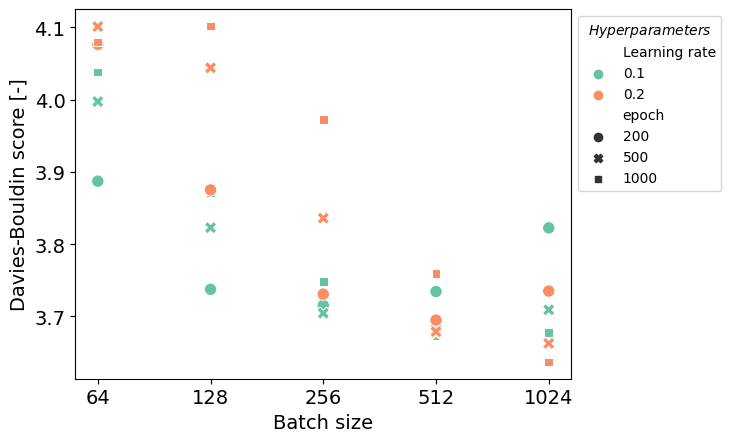

In [ ]:
ax = sns.scatterplot(df, y="DB score", x = "Batch size", hue="Learning rate", style="epoch", palette="Set2", s=80)
plt.legend(title=r"$\it{Hyperparameters}$", fontsize=16)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
labels = list(set(df["Batch size"].tolist()))
print(labels)
ax.set_xticks(labels)
ax.set_xlabel("Batch size", fontsize=14)
ax.set_ylabel("Davies-Bouldin score [-]", fontsize=14)
ax.set_xticklabels(labels, size = 14)
ax.yaxis.set_tick_params(labelsize=14)

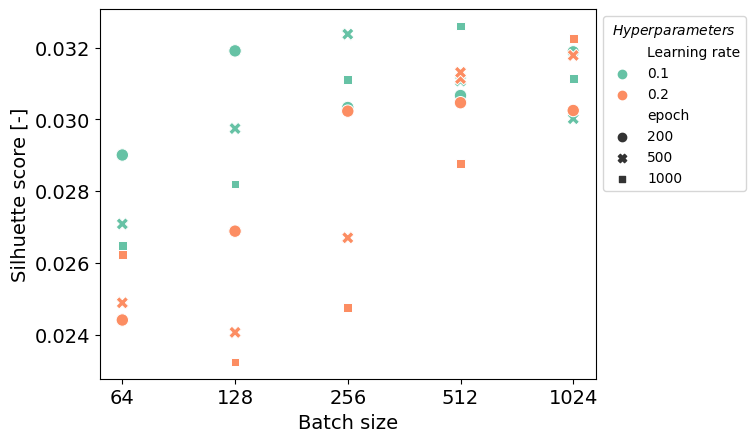

In [ ]:
ax = sns.scatterplot(df, y="Silhouette", x = "Batch size", hue="Learning rate", style="epoch", palette="Set2", s=80)
plt.legend(title=r"$\it{Hyperparameters}$", fontsize=16)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
labels = list(set(df["Batch size"].tolist()))
ax.set_xticks(labels)
ax.set_xlabel("Batch size", fontsize=14)
ax.set_ylabel("Silhuette score [-]", fontsize=14)
ax.set_xticklabels(labels, size = 14)
ax.yaxis.set_tick_params(labelsize=14)

In [ ]:
df.sort_values("DB score").head()

,Learning rate,epoch,Batch size,Loss,Validation loss,Silhouette,DB score
5,0.2,1000,1024,0.138306,0.352282,0.032255,3.636954
4,0.2,500,1024,0.155962,0.339236,0.031782,3.662619
31,0.1,1000,512,0.142078,0.350117,0.032604,3.673862
11,0.1,1000,512,0.142078,0.350117,0.032604,3.673862
19,0.2,500,512,0.140083,0.350931,0.031136,3.677031


In [ ]:
df.sort_values("DB score").head().to_csv(f"{path}/temp.csv", index=False)

<Axes: xlabel='Validation loss', ylabel='Silhouette'>

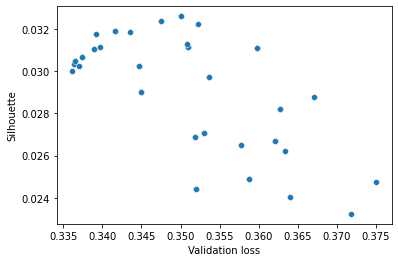

In [ ]:
sns.scatterplot(df, y="Silhouette", x = "Validation loss")

<Axes: xlabel='Validation loss', ylabel='DB score'>

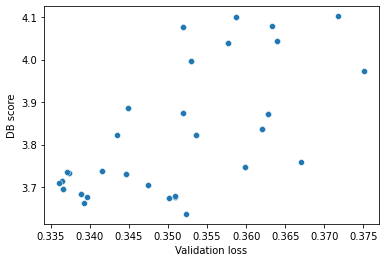

In [ ]:
sns.scatterplot(df, y="DB score", x = "Validation loss")